# T-DEV-810

- Jonathan Khalifa
- Valentin Noel
- Fabrice Sumsa
- Bastien Angles
- Kevan Sadeghi

    
# ball plot to see distribution of image height width? 71 -> 15:00
         




### Imports

In [383]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import math
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Global vars

In [384]:

BATCH_SIZE = 32 # as for mini-batch : 32 / 64 / 128
EPOCHS = 15
TRAIN_SAMPLE_SIZE = 4023 #1/3 each cat . 4023 for full set
IMG_SIZE = 180

### Load the Dataset

#### We will shuffle them in case they were set in a certain order.

In [385]:


# Load the training files
files_train_sick = glob.glob("/Users/jk/Downloads/chest_Xray/train/PNEUMONIA/*")
files_train_norm = glob.glob("/Users/jk/Downloads/chest_Xray/train/NORMAL/*")
files_test = glob.glob("/Users/jk/Downloads/chest_Xray/test/*/*")

# shuffle
random.shuffle(files_train_sick)
random.shuffle(files_train_norm)
random.shuffle(files_test)


print('We have ', len(files_train_sick) ,' pneumonia train files')
print('We have ', len(files_train_norm) ,' normal train files')



We have  3875  pneumonia train files
We have  1341  normal train files


### We separate bacterial from viral pneumonias and check the distribution

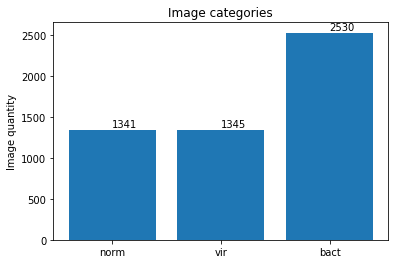

In [386]:

virus_files=[]#vir
bacteria_files=[]#bact
for file in files_train_sick:
    if("virus" in file):
        virus_files.append(file)
    if("bacteria" in file):
        bacteria_files.append(file)
        
# distrib plot 
x = ('norm', 'vir', 'bact')
y = [len(files_train_norm),len(virus_files),len(bacteria_files)]
plt.bar(x, height= y)
plt.ylabel('Image quantity')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

### We make a new training batch with equaly distributed image categories. 
#### Similar quantities of each category will make better training. 

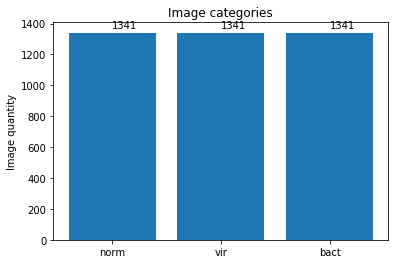

Total images in full equally distributed dataset :  4023
Total images in sample equally distributed dataset :  4023


In [387]:

# get cat with the less images
lowest = min([len(virus_files),len(bacteria_files),len(files_train_norm)])


# full training dataset will have "lowest val" images of each category
files_train_fullset = files_train_norm[:lowest] + virus_files[:lowest] + bacteria_files[:lowest]
random.shuffle(files_train_fullset)

# We will also make a smaller equally distributed dataset for testing purposes
train_subsample_size = int(TRAIN_SAMPLE_SIZE/3)
files_train_sample = files_train_norm[:train_subsample_size] + virus_files[:train_subsample_size] + bacteria_files[:train_subsample_size]
random.shuffle(files_train_sample)


# distrib plot 
x = ('norm', 'vir', 'bact')
y = [len(files_train_norm),len(files_train_norm),len(files_train_norm)]
plt.bar(x, height= y)
plt.ylabel('Image quantity')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

print('Total images in full equally distributed dataset : ', len(files_train_fullset))
print('Total images in sample equally distributed dataset : ', len(files_train_sample))


### We prepare the data
- We label the datasets using one-hot encoding
- We convert the images to RGB (3channels)
- We resize all images to same pixel height and width values
- We normalize the pixel values for better performance while training



In [388]:



# label , resize and RGB
def fixData(dataset):
    virus_count = 0
    bact_count = 0
    norm_count = 0
    y_data = []
    x_data = []
    for file in dataset:
        image = Image.open(file).convert('RGB')
        image = image.resize((IMG_SIZE, IMG_SIZE))
        data = np.array(image)
        
        x_data.append(data)
        
        if("virus" in file):
            target = 1
            virus_count += 1
        elif("bacteria" in file):
            target = 2
            bact_count += 1
        else:
            target = 0
            norm_count += 1

        y_data.append(target)    
    x_data = np.asarray(x_data)    
    y_data = np.asarray(y_data)
    y_data = to_categorical(y_data,3)
    return (x_data,y_data)


# Training images
###################################(x_train_full, y_train_full) = fixData(files_train_fullset)
(x_train_sample, y_train_sample) = fixData(files_train_sample)

# Testing images
(x_test, y_test) = fixData(files_test)







print("Features train sample shape : ", x_train_sample.shape)
print("Targets train sample shape  : ", y_train_sample.shape)
########################### print("Features train full shape : ", x_train_full.shape)
########################### print("Targets train full shape  : ", y_train_full.shape)
print("Features test shape : ", x_test.shape)
print("Targets test shape  : ", y_test.shape)







# Normalize data
def normData(data):
    xmax = data.max()
    data = data / xmax
    return data

print('Before normalization : min={}, max={}'.format(x_train_full.min(), x_train_sample.max()))
###################################### x_train_full = normData(x_train_full)
x_train_sample = normData(x_train_sample)
x_test = normData(x_test)
print('After normalisation  : min={}, max={}'.format(x_train_full.min(), x_train_sample.max()))





Features train sample shape :  (4023, 180, 180, 3)
Targets train sample shape  :  (4023, 3)
Features test shape :  (624, 180, 180, 3)
Targets test shape  :  (624, 3)
Before normalization : min=0.0, max=255
After normalisation  : min=0.0, max=1.0


### Check the Data

#### Here we will display a small sample of our clean dataset


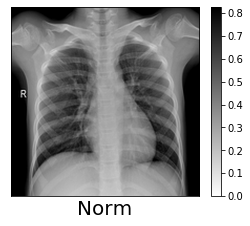

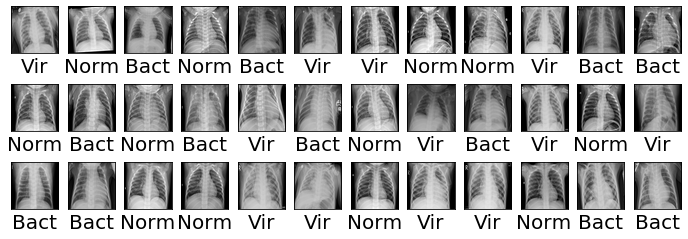

In [389]:


# Targets names for plotting
def targetNames(targets):
    target_names = []
    for target in targets:
        if(target[0] > 0):
            target_names.append("Norm")
        elif(target[1] > 0):
            target_names.append("Vir")
        elif(target[2] > 0):
            target_names.append("Bact")
    return target_names





def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    #save_fig(save_as)
    plt.show()


y_names = targetNames(y_train_sample)

plot_images(x_train_sample, y_names, [48], x_size=5, y_size=5, colorbar=True)
plot_images(x_train_sample, y_names, range(15,51), columns=12)

## Stats...

### The Model

szergzegzergzrgzergez

In [390]:





model = keras.models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

 

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 51200)           

## Train the model

In [399]:

#from tensorflow.keras.callbacks import EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss',patience=2)



history = model.fit(x_train_sample, y_train_sample,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   verbose = 1,
                   validation_data = (x_test, y_test)
                   #,callbacks=[early_stop])
                   )

Epoch 1/15
126/126 [==============================] - 123s 974ms/step - loss: 0.4256 - accuracy: 0.8016 - val_loss: 1.5393 - val_accuracy: 0.6987
Epoch 2/15
126/126 [==============================] - 129s 1s/step - loss: 0.3917 - accuracy: 0.8253 - val_loss: 1.5734 - val_accuracy: 0.6939
Epoch 3/15
126/126 [==============================] - 128s 1s/step - loss: 0.3638 - accuracy: 0.8327 - val_loss: 1.5147 - val_accuracy: 0.7019
Epoch 4/15
126/126 [==============================] - 130s 1s/step - loss: 0.3335 - accuracy: 0.8407 - val_loss: 2.0954 - val_accuracy: 0.6490
Epoch 5/15
126/126 [==============================] - 125s 992ms/step - loss: 0.3152 - accuracy: 0.8533 - val_loss: 1.7724 - val_accuracy: 0.6875
Epoch 6/15
126/126 [==============================] - 124s 986ms/step - loss: 0.2935 - accuracy: 0.8668 - val_loss: 2.2206 - val_accuracy: 0.6907
Epoch 7/15
126/126 [==============================] - 123s 976ms/step - loss: 0.2595 - accuracy: 0.8839 - val_loss: 2.2044 - val_accu

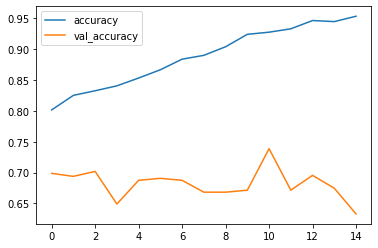

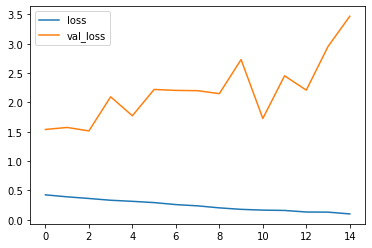

In [400]:
import pandas as pd
metrics = pd.DataFrame(history.history)
metrics.columns
metrics[['accuracy', 'val_accuracy']].plot()

metrics[['loss', 'val_loss']].plot()

##################################### check 69 -> 1:40 for explanations of these plots

['loss', 'accuracy']
20/20 [==============================] - 5s 264ms/step - loss: 3.4676 - accuracy: 0.6330
[3.467580556869507, 0.6330128312110901]


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

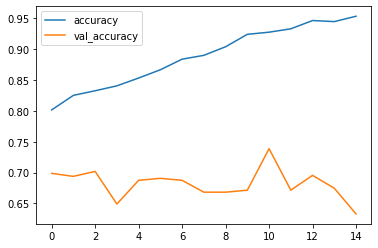

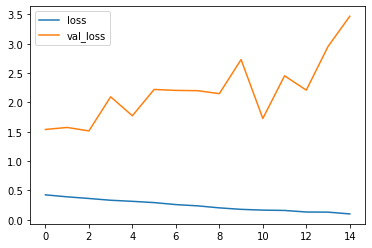

In [401]:
#Évaluation du Modèle
model.metrics_names
losses = pd.DataFrame(history.history)
losses.head()
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()
print(model.metrics_names)
print(model.evaluate(x_test,y_test,verbose=1))
from sklearn.metrics import classification_report,confusion_matrix

#put predictions and labels as single digit
predictions = np.argmax(model.predict(x_test), axis=1)
y_test_singleDigit = np.argmax(y_test, axis=1)

y_test.shape
y_test[0]
predictions[0]
y_test

              precision    recall  f1-score   support

           0       0.94      0.26      0.41       234
           1       0.40      0.80      0.54       148
           2       0.81      0.89      0.85       242

    accuracy                           0.63       624
   macro avg       0.72      0.65      0.60       624
weighted avg       0.76      0.63      0.61       624



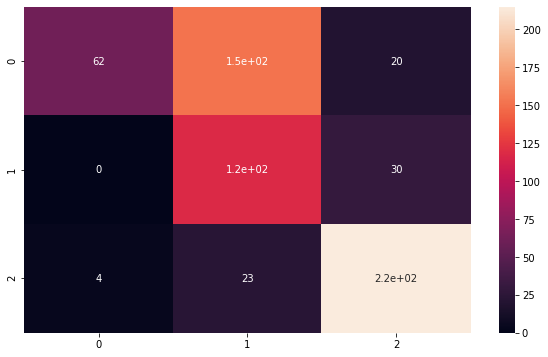

In [402]:
print(classification_report(y_test_singleDigit,predictions))
confusion_matrix(y_test_singleDigit,predictions)
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test_singleDigit,predictions),annot=True)
# https://github.com/matplotlib/matplotlib/issues/14751



image single digit label :  0
single digit label predicted by model :  [0]


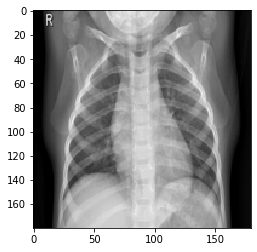

In [408]:
# test our predictions
my_image = x_test[490]
plt.imshow(my_image)

print('image single digit label : ', y_test_singleDigit[490])

pred = np.argmax(model.predict(my_image.reshape(1,IMG_SIZE,IMG_SIZE,3)), axis=1)
print('single digit label predicted by model : ', pred)